PARTE 0

In [1]:
import pandas as pd
import numpy as np
import timeit
import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy import optimize
from scipy import interpolate
from scipy.stats import linregress
from itertools import product 

In [2]:
%%time
#DATA AQUISITION
dataset0 = pd.read_csv("https://www.dropbox.com/s/ds2ah8jtouqn8rw/data_000000.txt?dl=1")

#info display
samples = dataset0.shape[0]
#print("Number of total hits:",samples)
ntriggers = dataset0[(dataset0['TDC_CHANNEL'] == 137) | (dataset0['TDC_CHANNEL'] == 138)].shape[0]
triggers = dataset0[dataset0['TDC_CHANNEL'] == 139].shape[0]
#print("Number of trigger 139 activations:",triggers)
#print("Percentage of trigger 139 wrt the total", triggers/samples*100)
#print("Percentage of trigger 137-8 wrt the total", ntriggers/samples*100)
total_orbits = dataset0['ORBIT_CNT'].nunique()
#print("Number of unique orbits:",total_orbits)

#display(dataset)

CPU times: user 524 ms, sys: 150 ms, total: 674 ms
Wall time: 2.84 s


In [3]:
%%time
dataset = dataset0.copy() #qui sto allungando artificialmente perché se no non posso rieseguire questa cella con il timeit
#add TIME and DETECTOR columns, drop HEAD and FPGA columns
dataset['TIME'] = dataset['BX_COUNTER']*25 + dataset['TDC_MEAS']*25/30 
fpga = dataset['FPGA'] == 1 
channel = (dataset['TDC_CHANNEL'] > 64) & (dataset['TDC_CHANNEL'] <= 128) 
trigger = dataset['TDC_CHANNEL'] == 139 

detectors = [~fpga & ~channel, ~fpga & channel, fpga & ~channel, fpga & channel]
for i in range(len(detectors)) : 
    dataset.loc[detectors[i],'DETECTOR'] = i+1 

dataset.loc[trigger,'DETECTOR'] = 0 

rest = dataset['TDC_CHANNEL'] % 4
dic_replace = {0:1, 2:2, 3:3, 1:4}
dataset['LAYER'] = rest
dataset['LAYER'].replace(dic_replace, inplace=True)
dataset.loc[trigger,'LAYER'] = 0 
dataset = dataset.drop(['HEAD','FPGA'],axis=1) 

#dataset

CPU times: user 266 ms, sys: 61.1 ms, total: 328 ms
Wall time: 314 ms


In [4]:
%%time
#identify events
def Identify_Events(x):
    
    if (x.TIME.max() - x.TIME.min()) < 415:
    
        x['EVENT'] = 1
        return x
    
    else:
        
        t1 = x.TIME.iloc[0]
        x1 =  x[np.abs(x.TIME.values - t1) < 415]
        x1['EVENT'] = 1
        
        xc = x[np.abs(x.TIME.values - t1) >= 415]
        i = 1
        while(xc.size != 0):
            
            i += 1
            t2 = xc.TIME.iloc[0]
            x2 =  xc[np.abs(xc.TIME.values - t2) < 415]
            x2['EVENT'] = i
            x1 = pd.concat([x1,x2])
            xc = xc[np.abs(xc.TIME.values - t2) >= 415]
        
        return x1

filtered1 = dataset.groupby('ORBIT_CNT', group_keys=False).apply(Identify_Events)
#filtered1

CPU times: user 12min 3s, sys: 5.65 s, total: 12min 9s
Wall time: 12min 10s


In [5]:
%%time
#display info on filtered1
events1 = filtered1.groupby(['ORBIT_CNT','EVENT']).nunique()
# print("Number of unique events:", len(events1))
# print("Samples in reduced dataset:", len(filtered1))
# print("Percentage of the original dataset:", len(filtered1)*100/samples,"%")

CPU times: user 1.89 s, sys: 41.9 ms, total: 1.93 s
Wall time: 1.95 s


In [6]:
%%time 
#function to cut groups smaller than 3 hits
def cut(group) :
    if group.shape[0] > 2 : return group
    else : return None
                 
filtered2=filtered1.groupby(['ORBIT_CNT', 'EVENT'],group_keys=False)\
                 .apply(cut)\
                 .dropna()\
                 .reset_index()\
                 .drop(['index'],axis=1)

orbits2 = len(filtered2.groupby(['ORBIT_CNT', 'EVENT']).nunique())

# print("Number of unique events:", orbits2)
# print("Samples in reduced dataset:", filtered2.shape[0])
# print("Percentage of the original dataset:", filtered2.shape[0]*100/samples,"%")


if orbits2 > triggers : 
    #print("NOTE:There are orbits with no trigger activation!")
    pass

#filtered2

CPU times: user 49.6 s, sys: 767 ms, total: 50.3 s
Wall time: 50.3 s


In [7]:
%%time
#function that selects events with trigger activation
def trigger(group) :
    if (group['DETECTOR'] != 0).all() : 
        return None
    else : 
        return group
                                         
filtered3 = filtered2.groupby(['ORBIT_CNT', 'EVENT'],group_keys=False)\
                     .apply(trigger)\
                     .dropna()\
                     .reset_index()\
                     .drop(['index'],axis=1)


orbits3 = len(filtered3.groupby(['ORBIT_CNT', 'EVENT']).nunique())

# print("Number of unique events:", orbits3)
# print("Samples in reduced dataset:", filtered3.shape[0])
# print("Percentage of the original dataset:", filtered3.shape[0]*100/samples,"%")

if orbits3 > triggers :
    #print("ERROR!")
    pass
else :
    #print("NOTE:Multiple trigger activations in the same ORBIT_CNT!")
    pass
    
#filtered3

CPU times: user 52.3 s, sys: 783 ms, total: 53.1 s
Wall time: 52.8 s


In [8]:
%%time
#useless at this point

#sort each group by time

ordered = filtered3.groupby(['ORBIT_CNT', 'EVENT'],group_keys=False)\
                   .apply(lambda x: x.sort_values(['TIME']))\
                   .reset_index()\
                   .drop(['index'],axis=1)

#ordered

CPU times: user 43 s, sys: 365 ms, total: 43.4 s
Wall time: 43.4 s


In [9]:
%%time
def clean(group):
    
    group1 = group.drop(group[group['DETECTOR'] == 0].index) #event without trigger
    
    detector = group1.DETECTOR.mode().values #value of most common detector
    
    indices = group1[group1['DETECTOR'] != detector[0]].index #indices of event not corresponding to major detector
    group = group.drop(indices) #clean event
    
    return group

#clean the events
filtered4 = ordered.groupby(['ORBIT_CNT', 'EVENT'],group_keys=False)\
                   .apply(clean)\
                   .dropna()\
                   .reset_index()\
                   .drop(['index'],axis=1) #LONG RUNTIME!!!


orbits4 = len(filtered4.groupby(['ORBIT_CNT', 'EVENT']).nunique())
hits4 = filtered4.shape[0]
# print("Number of unique orbits:", orbits4)
# print("Samples in reduced dataset:", hits4)
# print("Percentage of the original dataset:", hits4*100/samples,"%")


# filtered4

CPU times: user 3min 8s, sys: 733 ms, total: 3min 9s
Wall time: 3min 9s


In [10]:
%%time
filtered4 = filtered4.groupby(['ORBIT_CNT', 'EVENT'],group_keys=False)\
                     .apply(cut)\
                     .dropna()\
                     .reset_index()\
                     .drop(['index'],axis=1)
#print("There are:", hits4-filtered4.shape[0], "samples less than the previous cut")

CPU times: user 11.9 s, sys: 159 ms, total: 12.1 s
Wall time: 12.1 s


In [11]:
#solo a titolo informativo, non serve ai fini di cosa segue quindi non ci perdo tempo
# %%time
# # questa funzione conta le orbits in cui ci sono quattro layer attivati. Calcoliamo poi la percentuale di eventi siffatti rispetto al totale (unique orbits)
# def countlayers(group):
#     if group['LAYER'].nunique() > 3:
#         return group
#     else: return None
# lessthan3df = filtered4.groupby(['ORBIT_CNT', 'EVENT'],group_keys=False)\
#                        .apply(countlayers)\
#                        .dropna()\
#                        .reset_index()\
#                        .drop(['index'],axis=1)

# lessthan3orbits = len(lessthan3df.groupby(['ORBIT_CNT', 'EVENT']).nunique())
# print("Events having all four layers activated are:",lessthan3orbits/orbits4*100,"wrt the previous filtering procedure")

In [12]:
#solo a titolo informativo, non serve ai fini di cosa segue quindi non ci perdo tempo
# %%time
# # QUANTI SONO PERO I BUCHI NELL'UN PERCENTO 
# def hole(group):
#     if group['LAYER'].nunique() < 4:
#         if ((group['LAYER']==1).any())and((group['LAYER']==2).any())and((group['LAYER']==4).any()) :
#             return group
#         elif ((group['LAYER']==1).any())and((group['LAYER']==3).any())and((group['LAYER']==4).any()) :
#             return group
#         else : 
#             return None
#     else : 
#         return None 
# holes = filtered4.groupby(['ORBIT_CNT', 'EVENT'],group_keys=False)\
#                  .apply(hole)\
#                  .dropna()\
#                  .reset_index()\
#                  .drop(['index'],axis=1)
# holes
# #nholes = holes['ORBIT_CNT'].nunique()
# #nholes 

In [13]:
%%time
def all_layers(group) :
    if group['LAYER'].nunique() > 2 :
        return group
    else :
        return None

filtered5 = filtered4.groupby(['ORBIT_CNT', 'EVENT'],group_keys=False)\
                     .apply(all_layers)\
                     .dropna()\
                     .reset_index()\
                     .drop(['index'],axis=1) 


orbits5 = len(filtered5.groupby(['ORBIT_CNT', 'EVENT']).nunique())

# print("Number of unique orbits:", orbits5)
# print("Samples in reduced dataset:", filtered5.shape[0])
# print("Percentage of the original dataset:", filtered5.shape[0]*100/samples,"%")


# filtered5

CPU times: user 29.4 s, sys: 485 ms, total: 29.9 s
Wall time: 29.8 s


In [14]:
%%time
def more_layers(group) : 
    if len(group['LAYER']) != len(set(group['LAYER'])) : 
        return None 
    else : 
        return group

filtered6 = filtered5.groupby(['ORBIT_CNT', 'EVENT'],group_keys=False)\
                     .apply(more_layers)\
                     .dropna()\
                     .reset_index()\
                     .drop(['index'],axis=1)

orbits6 = len(filtered6.groupby(['ORBIT_CNT', 'EVENT']).nunique())

# print("Number of unique orbits:", orbits6)
# print("Samples in reduced dataset:", filtered6.shape[0])
# print("Percentage of the original dataset:", filtered6.shape[0]*100/samples,"%")

# filtered6

CPU times: user 18.3 s, sys: 243 ms, total: 18.5 s
Wall time: 18.5 s


In [15]:
%%time
#function to draw hit cells
def centres(ev):
    
    ev=ev.drop(ev[ev['DETECTOR'] == 0].index).reset_index().drop(['index'],axis=1) #drop the trigger hit
    
    dx=1
    dy=1/2
    
    x = np.zeros(ev.shape[0])
    y = np.zeros(ev.shape[0])
    
    if (ev['TDC_CHANNEL']>64).all() : 
        ev['TDC_CHANNEL'] -= 64 

    
    for i in range(ev.shape[0]): 
        
        layer = ev.loc[i,'LAYER']
        channel = ev.loc[i,'TDC_CHANNEL']

        if layer == 1 : 
            x[i] = channel/4
            y[i] = 1/4
        
        elif layer == 2 :
            x[i] = (channel+2)/4 + dx/2 
            y[i] = 3/4
        
        elif layer == 3 :
            x[i] = (channel+1)/4
            y[i] = 5/4
        
        elif layer == 4 : 
            x[i] = (channel+3)/4 + dx/2 
            y[i] = 7/4
        
            
    return [x,y]

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs


In [16]:
%%time
#function to plot interested boxes

def boxes(ax,x,y):
    
    dx = 1
    dy = 1/2
     
    #draw interested boxes
    for i in range(len(x)) :
        rect = patches.Rectangle((x[i]-dx/2,y[i]-dy/2),dx,dy,linewidth=3,edgecolor='r',facecolor='none')
        ax.add_patch(rect)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


In [17]:
%%time


def draw_detector(ax) :
    
    dx = 1
    dy = 1/2

    ax.set_xlim(0,16.5)
    ax.set_ylim(-0.2,2.2)
    
    x_1 = np.arange(1,16)-dx/2
    y_1 = 0
    
    x_2 = x_1 + dx/2
    y_2 = dy
    
    x_3 = x_1
    y_3 = 2*dy
    
    x_4 = x_2
    y_4 = 3*dy
    
    for i in range(15):
        rect = patches.Rectangle((x_1[i],y_1),dx,dy,linewidth=1,edgecolor='black',facecolor='none')
        ax.add_patch(rect)
    
        rect = patches.Rectangle((x_2[i],y_2),dx,dy,linewidth=1,edgecolor='black',facecolor='none')
        ax.add_patch(rect)
    
        rect = patches.Rectangle((x_3[i],y_3),dx,dy,linewidth=1,edgecolor='black',facecolor='none')
        ax.add_patch(rect)
        
        rect = patches.Rectangle((x_4[i],y_4),dx,dy,linewidth=1,edgecolor='black',facecolor='none')
        ax.add_patch(rect)
        
        ax.axis('off')


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


In [18]:
%%time
#esempio
events = [value for value in filtered6.groupby(['ORBIT_CNT', 'EVENT']).groups.values()]
triggers_139 = filtered6[filtered6['TDC_CHANNEL']==139]

event = [filtered6.loc[events[i]].drop(triggers_139.iloc[i].name) for i in range(6)]
#event[4]

CPU times: user 1.36 s, sys: 47 ms, total: 1.41 s
Wall time: 1.41 s


CPU times: user 427 ms, sys: 0 ns, total: 427 ms
Wall time: 435 ms


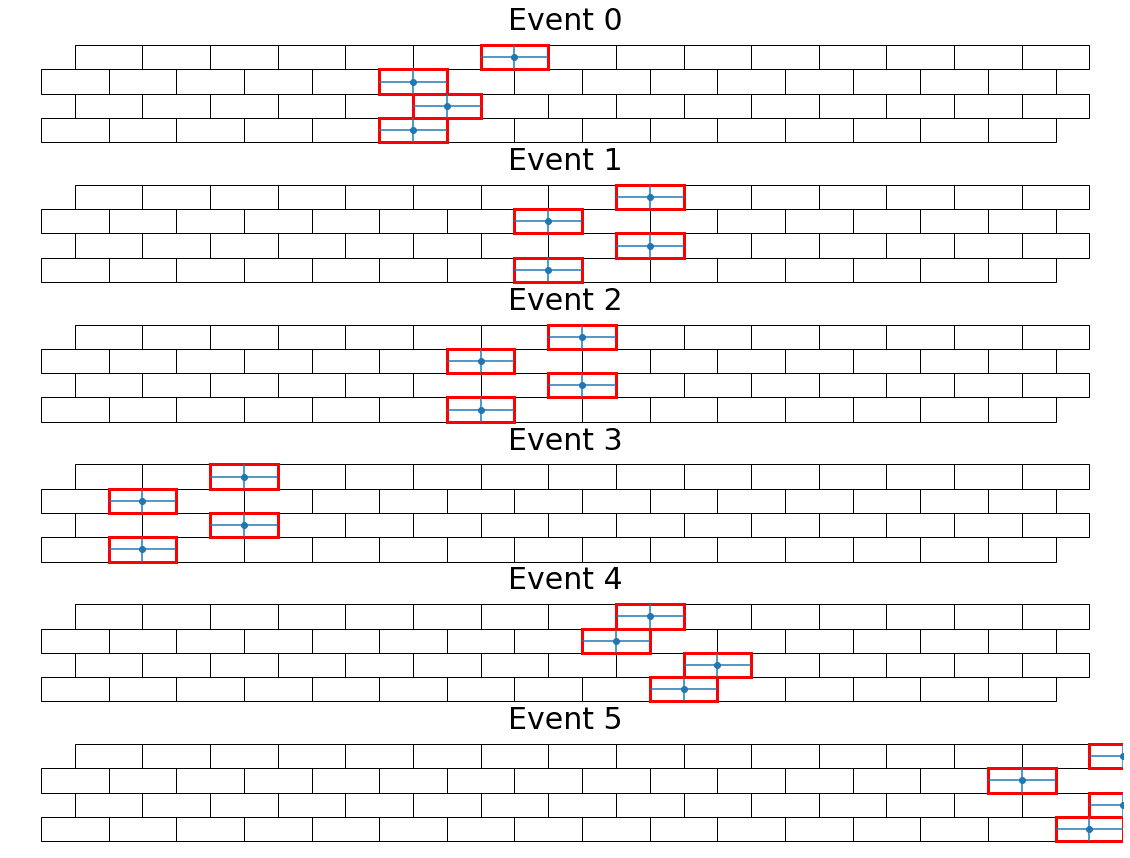

In [19]:
%%time
#plot
dx = 1
dy = 1/2

fig,ax = plt.subplots(nrows=6,ncols=1,figsize=(20,15))

for i in range(6):
    ax[i].set_title("Event %d" %i,fontsize=30)
    draw_detector(ax[i])
    boxes(ax[i],centres(event[i])[0],centres(event[i])[1])
    ax[i].errorbar(*centres(event[i]),dy/2,dx/2,fmt='o') 

#plt.show()


In [20]:
%%time
#vicinanza
def close(group):
    
    group1 = group.drop(group[group['DETECTOR']==0].index)\
                  .sort_values('LAYER')
    
    x = pd.Series(centres(group1)[0]).diff().abs() 
    if (x>1).any() == True: 
        return None
  
    else : 
        return group
    
    
filtered7 = filtered6.groupby(['ORBIT_CNT', 'EVENT'],group_keys=False)\
                     .apply(close)\
                     .dropna()\
                     .reset_index()\
                     .drop(['index'],axis=1) 


orbits7 = len(filtered7.groupby(['ORBIT_CNT', 'EVENT']).nunique())

# print("Number of unique orbits:",orbits7)
# print("Samples in reduced dataset:",filtered7.shape[0])
# print("Percentage of the original dataset:",filtered7.shape[0]*100/samples,"%")


# filtered7

CPU times: user 4min 48s, sys: 584 ms, total: 4min 49s
Wall time: 4min 49s


In [21]:
%%time
#vicinanza con buchi

def closep(group):
    group1 = group.drop(group[group['DETECTOR'] == 0].index)\
    .sort_values('LAYER')
    
    x = pd.Series(centres(group1)[0]).diff().abs() 
    if x in {[None, 1, 2],[None, 2, 1],[None, 0, 1],[None, 1, 0]}: return group 

    else : 
        return None

holes1 = filtered6.groupby(['ORBIT_CNT', 'EVENT'],group_keys=False)\
                  .apply(hole)\
                  .dropna()\
                  .reset_index()\
                  .drop(['index'],axis=1)
#holes1

NameError: ignored

In [22]:
%%time
#fine buchi
try : #quanto segue fallisce se filteredholes è vuoto
    filteredholes = holes1.groupby(['ORBIT_CNT', 'EVENT'],group_keys=False)\
                          .apply(closep)\
                          .dropna()\
                          .reset_index()\
                          .drop(['index'],axis=1)
    filtered7 = pd.concat(filtered7,filteredholes,ignore_index=True)
    orbits7 = len(filtered7.groupby(['ORBIT_CNT', 'EVENT']).nunique())

    print("Number of unique orbits:",orbits7)
    print("Samples in reduced dataset:",filtered7.shape[0])
    print("Percentage of the original dataset:",filtered7.shape[0]*100/samples,"%")

    filtered7
except: pass

CPU times: user 10 µs, sys: 0 ns, total: 10 µs
Wall time: 14.8 µs


CPU times: user 966 ms, sys: 24 ms, total: 990 ms
Wall time: 994 ms


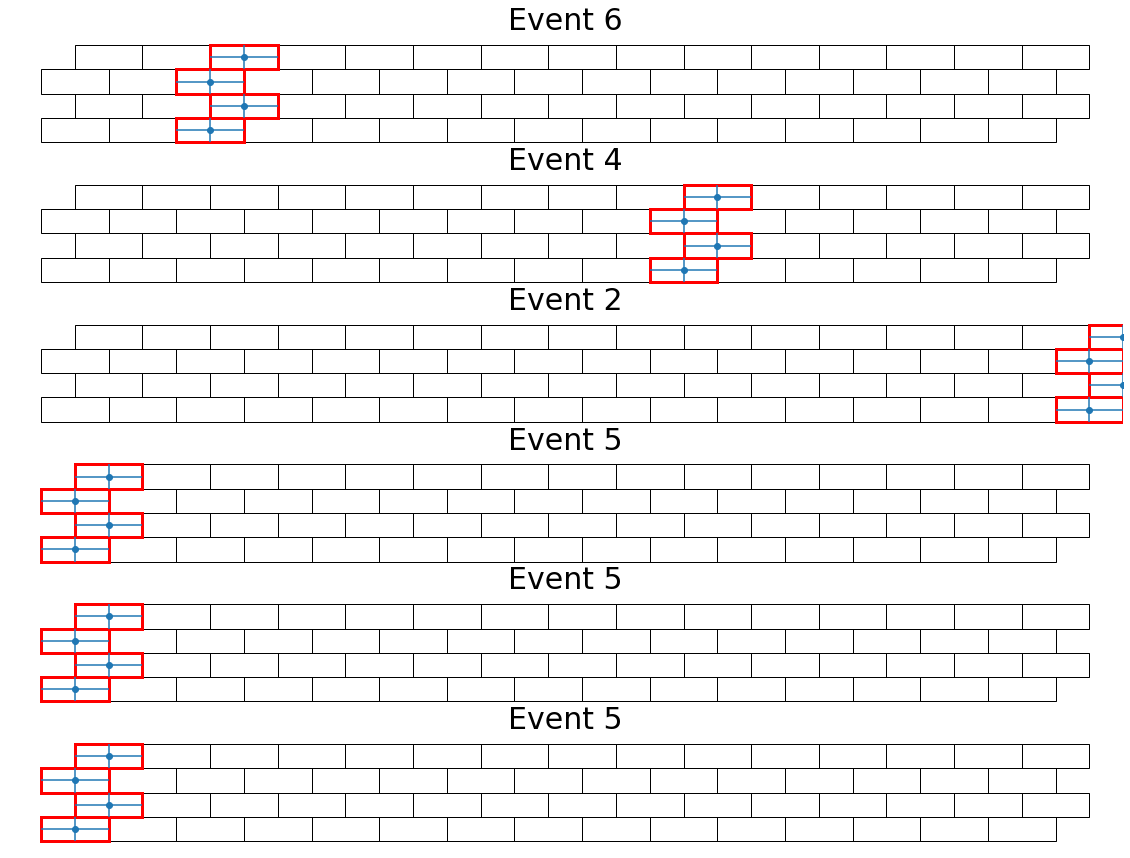

In [23]:
%%time 
#esempio+plot
events = [value for value in filtered7.groupby(['ORBIT_CNT', 'EVENT']).groups.values()]
triggers_139 = filtered7[filtered7['TDC_CHANNEL']==139]
randomin = np.random.randint(10,size=6)
event = [filtered7.loc[events[i]].drop(triggers_139.iloc[i].name) for i in randomin]

dx = 1
dy = 1/2

fig,ax = plt.subplots(nrows=6,ncols=1,figsize=(20,15))

for i,j in zip(range(6), randomin):
    ax[i].set_title("Event %d" %j,fontsize=30)
    draw_detector(ax[i])
    boxes(ax[i],centres(event[i])[0],centres(event[i])[1])
    ax[i].errorbar(*centres(event[i]),dy/2,dx/2,fmt='o') 
#plt.show()

PARTE 1

In [24]:
%%time
#acquisizione dati dalla parte precedente+assegnazione time pedestal column

#dataset = pd.read_csv("dati_LS1.csv")
df = filtered7.copy()
df["TIME_PEDESTAL"] = np.nan

def assign_time_pedestal(group) :
    t0 = group["TIME"][group.DETECTOR == 0].values 
    group["TIME_PEDESTAL"][group.DETECTOR != 0] = t0 
    return group

df = df.groupby(['ORBIT_CNT',"EVENT"],group_keys=False)\
                   .apply(assign_time_pedestal)\
                   .reset_index()\
                   .drop(['index'],axis=1)

df["DRIFT_TIME"] = np.abs(df.TIME.values - df.TIME_PEDESTAL)
df["HOR_AMBIG_COORD"] = 42/(2*390)*df.DRIFT_TIME
#df

CPU times: user 53.6 s, sys: 698 ms, total: 54.3 s
Wall time: 54.3 s


In [25]:
%%time
#scarto al volo quelli con drift times troppo grandi
Tmax = 390
experimental_time_uncertainty = 50 #25*2 
T = Tmax + experimental_time_uncertainty

#print("max drift time within acceptability window:",df[df.DRIFT_TIME < T].DRIFT_TIME.max())

def cut(group) : #già definita in cima ma la lascio
    if group.shape[0] > 2 : return group
    else : return None
                        
df = (df[df.DRIFT_TIME < T]).groupby(['ORBIT_CNT'],group_keys=False).apply(cut)\
                                                                    .dropna()\
                                                                    .reset_index()\
                                                                    .drop(['index'],axis=1)
#df 

CPU times: user 3.36 s, sys: 35 ms, total: 3.4 s
Wall time: 3.41 s


In [26]:
%%time
#add column coordinate of the cell
def minus64(x):
    if x < 65:
        return x
    else:
        return x - 64

df["COLUMN"] = ((df['TDC_CHANNEL'].apply(minus64) + interpolate.BarycentricInterpolator([1,2,3,4],[0,2,1,3])(df["LAYER"])) / 4).astype(int)
#df

CPU times: user 71.4 ms, sys: 12 ms, total: 83.4 ms
Wall time: 70.5 ms


CPU times: user 5.47 s, sys: 10 ms, total: 5.48 s
Wall time: 5.48 s


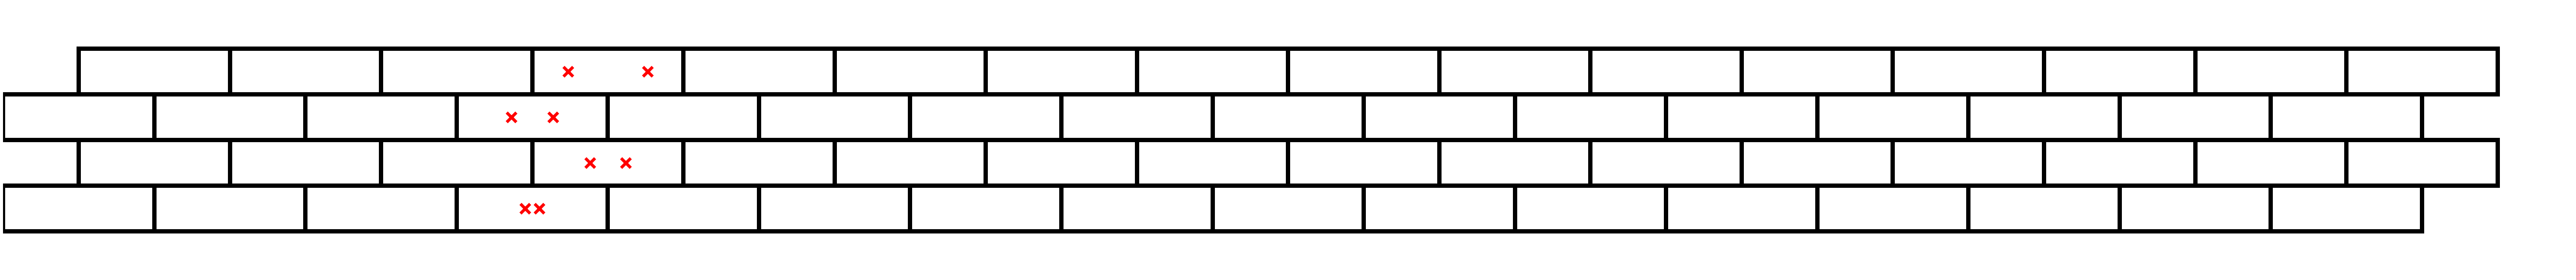

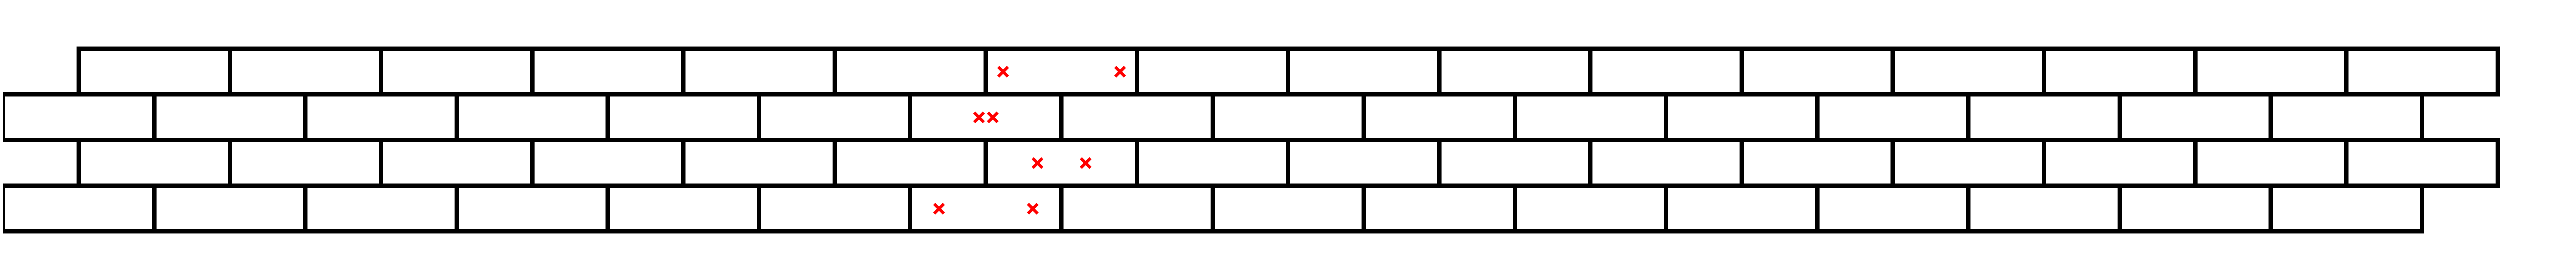

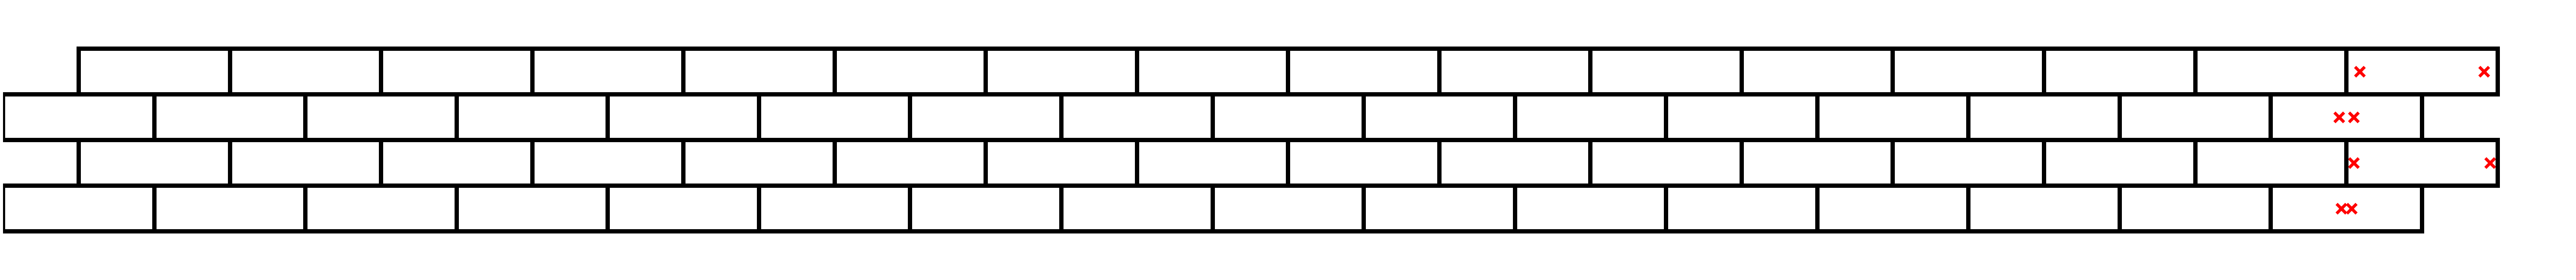

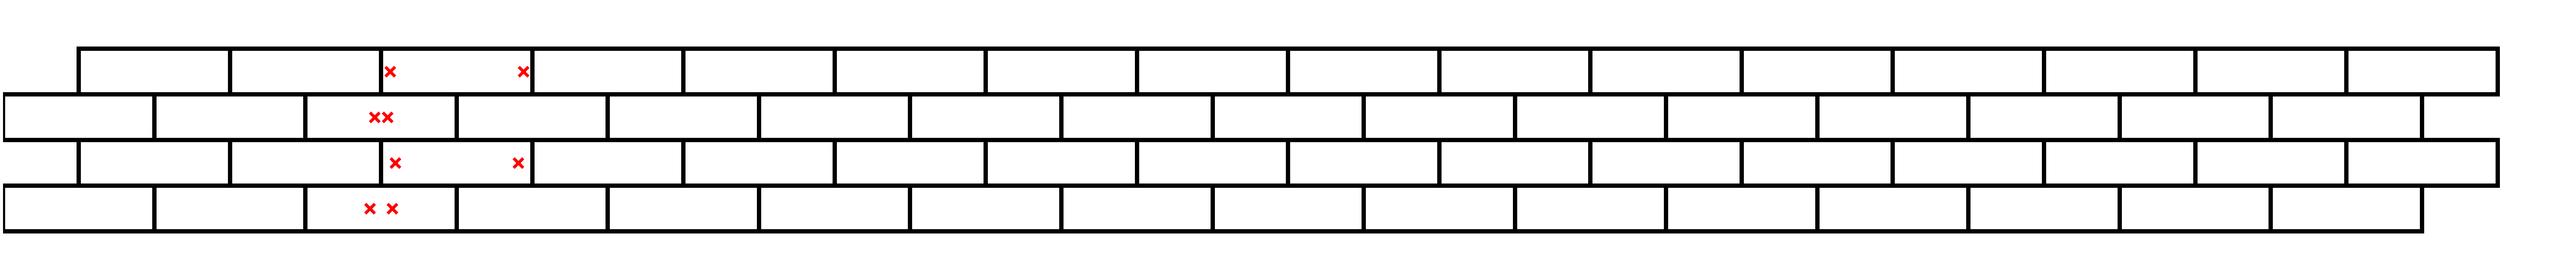

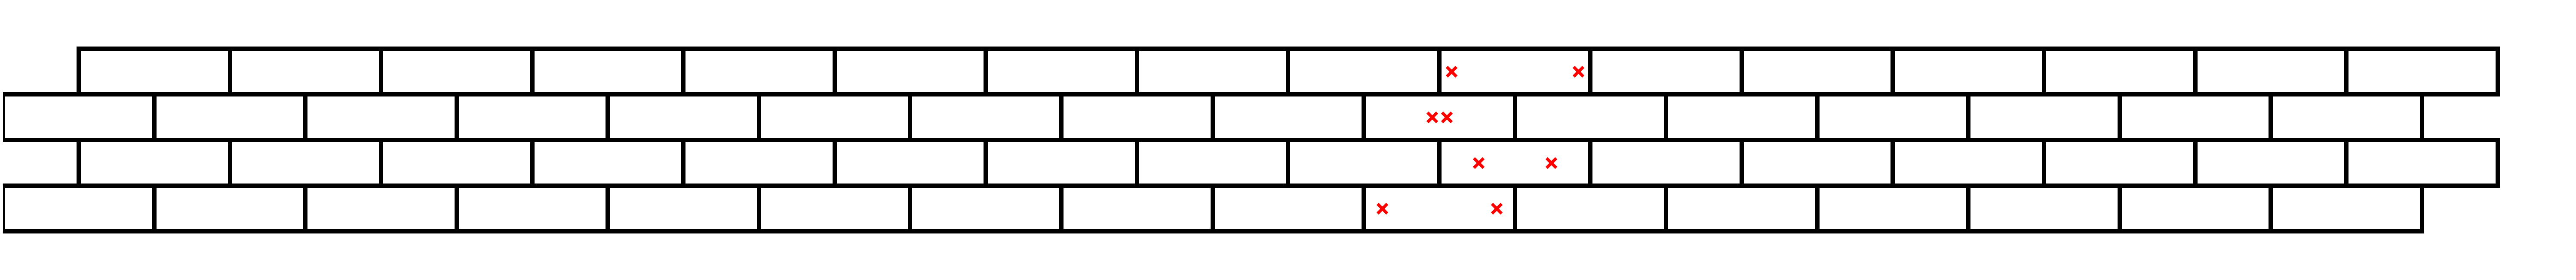

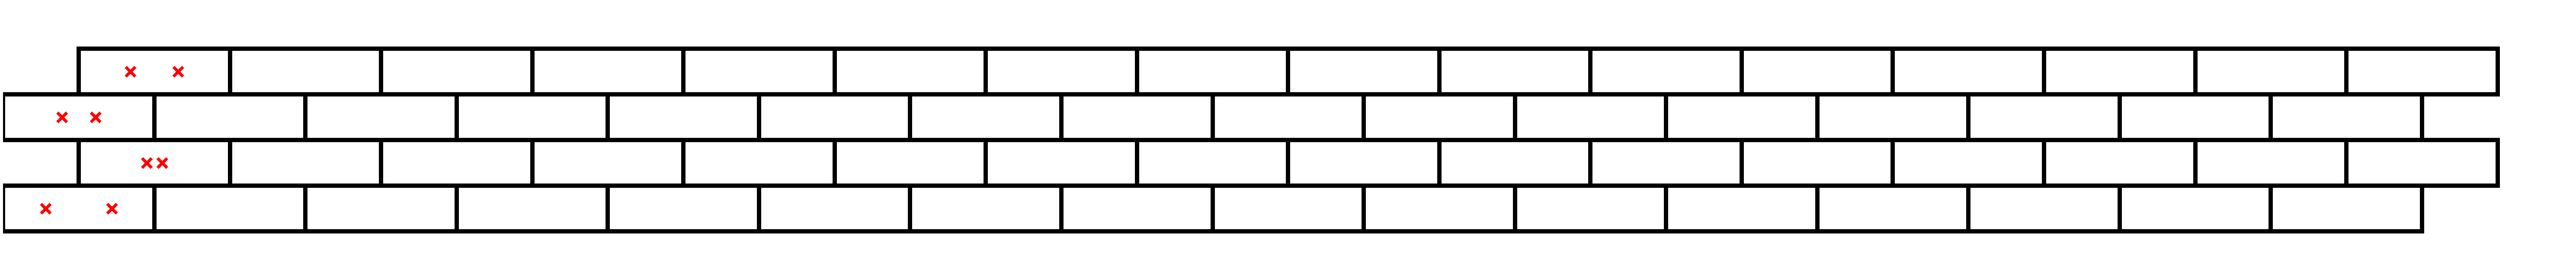

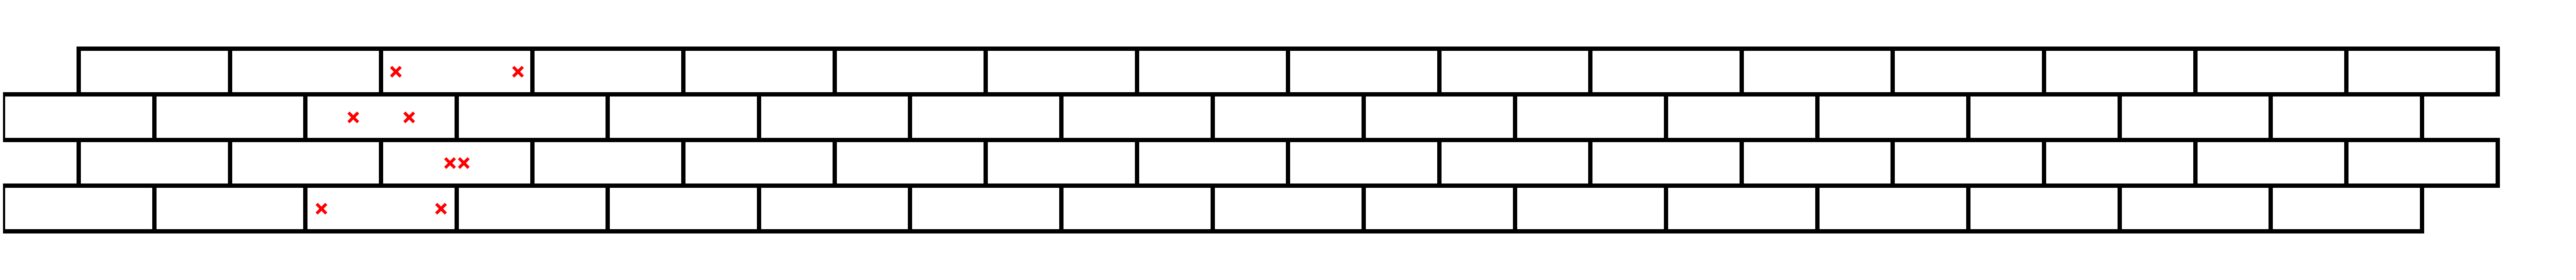

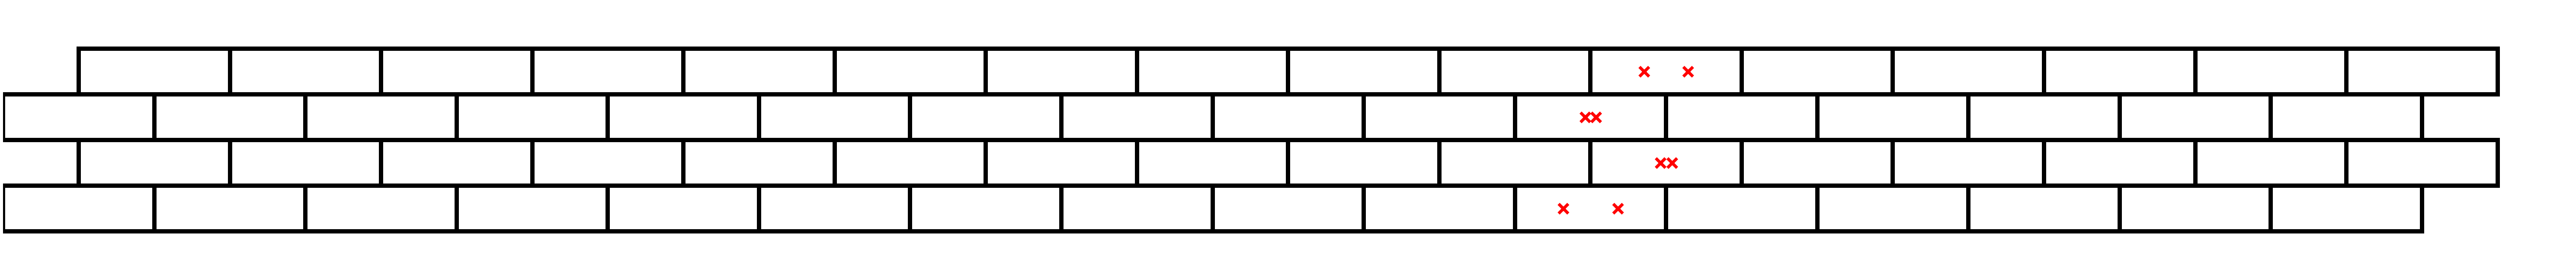

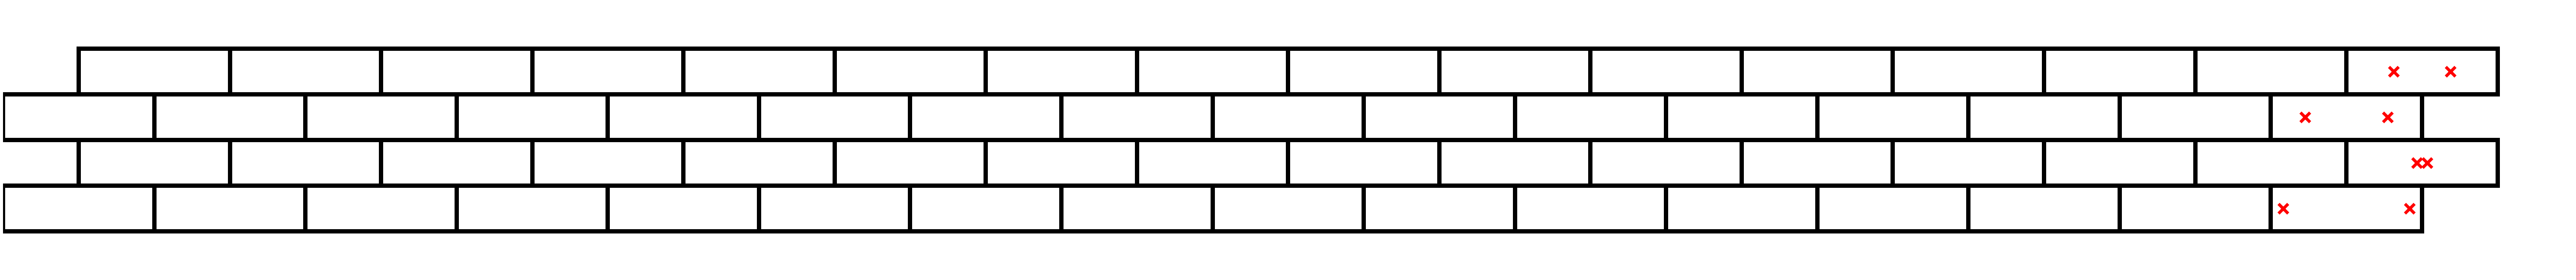

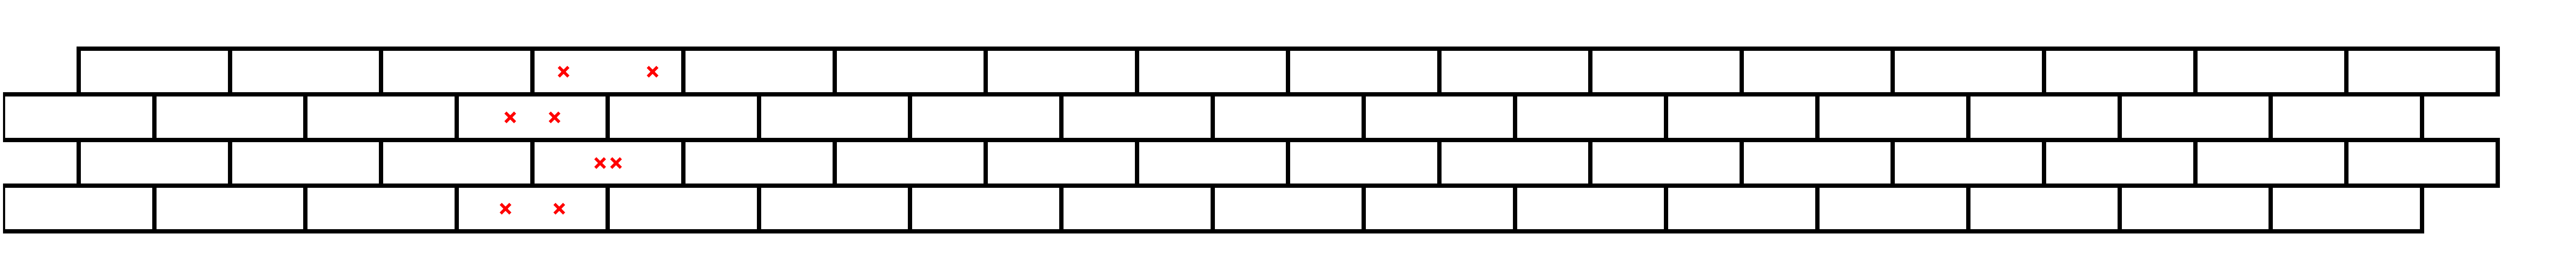

In [27]:
%%time
#plot

def event_plot(event):
    
    fig,ax1 = plt.subplots(figsize=(1.5*4.2*17,1.5*1.3*6))
    
    dx = 42
    dy = 13
    
    x = []
    y = []
    for i in range(len(event)):
        hit = event.iloc[i] 
        y1 = dy * (hit.LAYER-1/2)
        y.append(y1)
        y.append(y1)

        if hit.LAYER % 2 != 0 : 
            x1 = dx * (hit.COLUMN - 1/2) + hit.X 
            x2 = dx * (hit.COLUMN - 1/2) - hit.X
            x.append(x1)
            x.append(x2)
        else :
            x1 = dx * hit.COLUMN + hit.X 
            x2 = dx * hit.COLUMN - hit.X 
            x.append(x1)
            x.append(x2)
            

    ax1.set_xlim(0,42*16 + 42)
    ax1.set_ylim(-13,13*4 + 13)

    x_1 = x_3 = np.arange(16)*dx 
    x_2 = x_4 = x_1 + dx/2
    [y_1, y_2, y_3, y_4] = np.arange(4)*dy 
    
    for i in range(16):
        rect = patches.Rectangle((x_1[i],y_1),dx,dy,linewidth=10,edgecolor='black',facecolor='none')
        ax1.add_patch(rect)
    
        rect = patches.Rectangle((x_2[i],y_2),dx,dy,linewidth=10,edgecolor='black',facecolor='none')
        ax1.add_patch(rect)
    
        rect = patches.Rectangle((x_3[i],y_3),dx,dy,linewidth=10,edgecolor='black',facecolor='none')
        ax1.add_patch(rect)
        
        rect = patches.Rectangle((x_4[i],y_4),dx,dy,linewidth=10,edgecolor='black',facecolor='none')
        ax1.add_patch(rect)
        
        ax1.axis('off')
        
    ax1.scatter(x,y, marker = 'x', c = 'red', s = 500, linewidth = 7)
    return ax1

try :
    df.rename(columns={"HOR_AMBIG_COORD":"X"},inplace=True) #fallisce rieseguendo la cella
except:
    pass

for i in np.unique(df.ORBIT_CNT.values)[:10]:
    try:
        event = df.groupby(['ORBIT_CNT','EVENT']).get_group((i,1))
        event_plot(event)
    except:
        event = df.groupby(['ORBIT_CNT']).get_group(i)
        event_plot(event)

In [28]:
# %%time
# df.hist(column = 'DRIFT_TIME',bins=5);

PARTE 2

In [29]:
%%time
#acquisizione
dataset = df

CPU times: user 147 µs, sys: 1 µs, total: 148 µs
Wall time: 154 µs


In [30]:
%%time
#eliminazione e creazione di colonne a seconda della loro utilità
df = dataset.copy() 
df = df[["ORBIT_CNT","LAYER","EVENT","X","COLUMN"]]#tengo orbit, event, layer, column, x riassegnando a df se stesso a cui accedo mediante la lista delle colonne di interesse
df["XR"] = np.nan
df["XL"] = np.nan
#display(df)

CPU times: user 13.1 ms, sys: 0 ns, total: 13.1 ms
Wall time: 13.4 ms


In [31]:
%%time
#xr, xl
def compute_xr_xl(hit) :
    dx = 42

    if hit.LAYER.to_numpy(dtype=int) % 2 != 0 : 
            hit["XR"] = dx * (hit.COLUMN - 1/2) + hit.X
            hit["XL"] = dx * (hit.COLUMN - 1/2) - hit.X
    else :
        hit["XR"] = dx * hit.COLUMN + hit.X 
        hit["XL"] = dx * hit.COLUMN - hit.X 
    return hit

df = df.groupby(["ORBIT_CNT","EVENT","LAYER"],group_keys=False).apply(compute_xr_xl) 
#display(df)

CPU times: user 2min 54s, sys: 2.27 s, total: 2min 56s
Wall time: 2min 56s


In [32]:
%%time
#colonna Y
dy = 13 #altezza singolo rettangolo in mm
df["Y"] = dy * (df.LAYER-1/2)
display(df)

,ORBIT_CNT,LAYER,EVENT,X,COLUMN,XR,XL,Y
0,1.897417e+09,4.0,1.0,11.038462,4,179.038462,156.961538,45.5
1,1.897417e+09,2.0,1.0,4.980769,4,172.980769,163.019231,19.5
2,1.897417e+09,1.0,1.0,1.929487,4,148.929487,145.070513,6.5
3,1.897417e+09,3.0,1.0,5.788462,4,152.788462,141.211538,32.5
4,1.897417e+09,4.0,1.0,16.288462,7,310.288462,277.711538,45.5
...,...,...,...,...,...,...,...,...
114079,1.920940e+09,3.0,1.0,8.166667,5,197.166667,180.833333,32.5
114080,1.920940e+09,3.0,1.0,5.205128,14,572.205128,561.794872,32.5
114081,1.920940e+09,1.0,1.0,1.705128,14,568.705128,565.294872,6.5
114082,1.920940e+09,2.0,1.0,3.589744,14,591.589744,584.410256,19.5


CPU times: user 36.4 ms, sys: 1.01 ms, total: 37.4 ms
Wall time: 41.4 ms


In [33]:
%%time
#solve ambiguity
def solve_ambiguity(event):
    combin = np.array(list(product(*event.loc[:, ['XR','XL']].to_numpy())))
    if combin.shape[1] != event.Y.shape[0] :
        print("X.shape and Y.shape don't match")
        return None 
    r = np.zeros(combin.shape[0]) 
    for i in range(combin.shape[0]) :
        r[i] = np.corrcoef(combin[i],event.Y)[0,1] 
    event['X_BEST'] = combin[np.abs(r).argmax()]
    return event

df1 = df.groupby(['ORBIT_CNT','EVENT'], group_keys=False)\
                                       .apply(solve_ambiguity)\
                                       .reset_index()\
                                       .drop(['index'],axis=1) 
#df1

CPU times: user 1min 48s, sys: 416 ms, total: 1min 48s
Wall time: 1min 49s


In [34]:
%%time
#m e q
def meq(event):
    res = linregress(x=event['X_BEST'].to_numpy(),y=event['Y'].to_numpy())
    event['M'] = res.slope
    event['Q'] = res.intercept
    return event

df2 = df1.groupby(['ORBIT_CNT','EVENT'], group_keys=False)\
                                       .apply(meq)\
                                       .reset_index()\
                                       .drop(['index'],axis=1) 
#df2

CPU times: user 52.7 s, sys: 334 ms, total: 53 s
Wall time: 53.1 s


CPU times: user 5.57 s, sys: 3.93 ms, total: 5.58 s
Wall time: 5.59 s


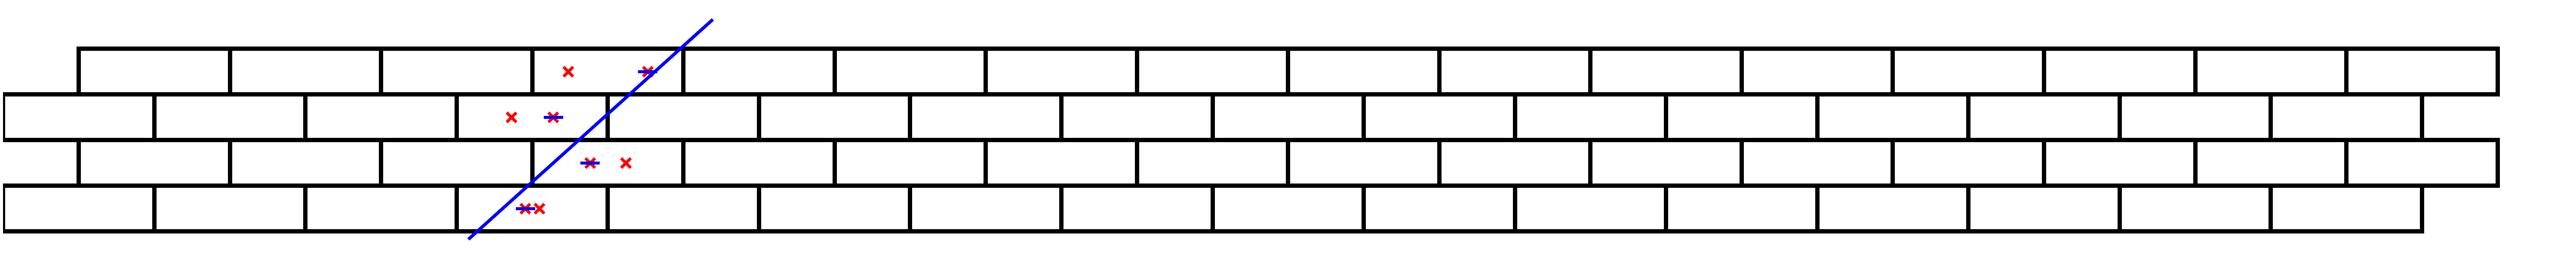

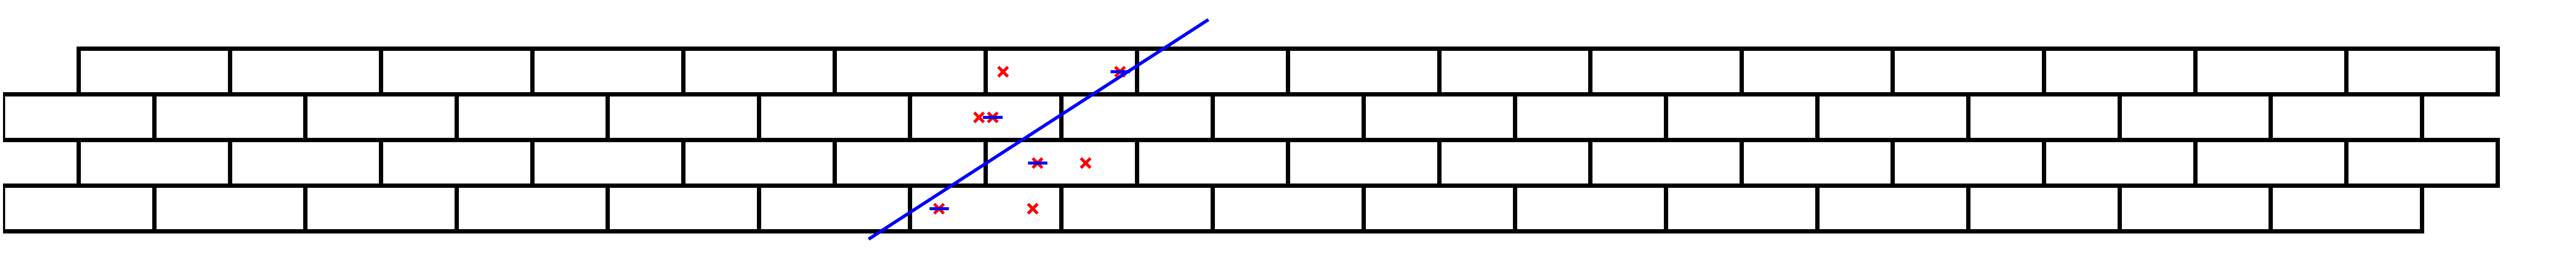

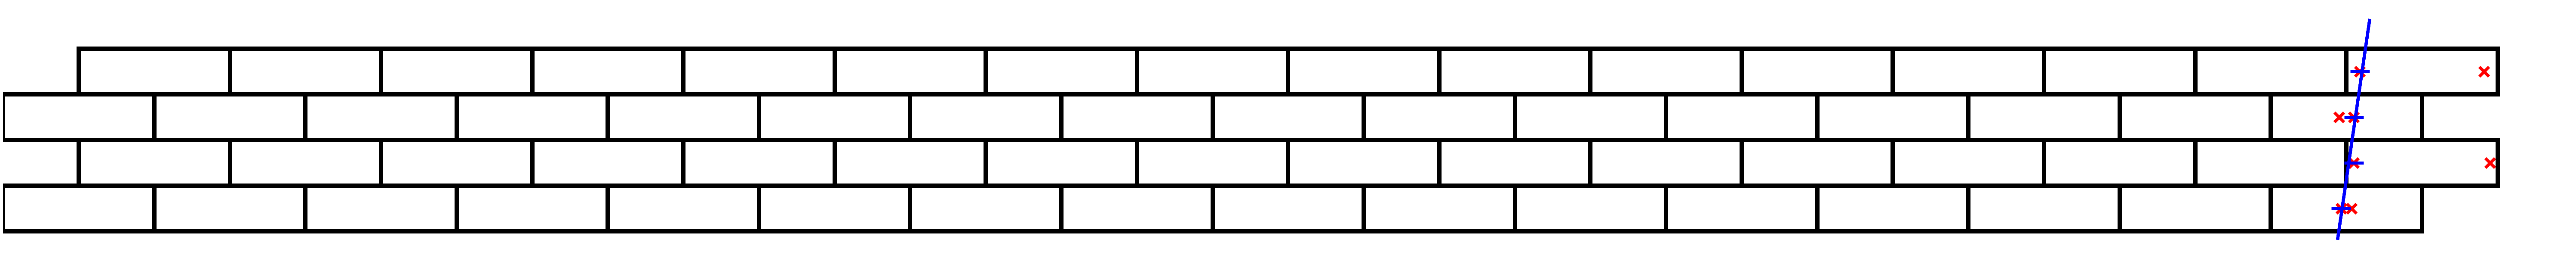

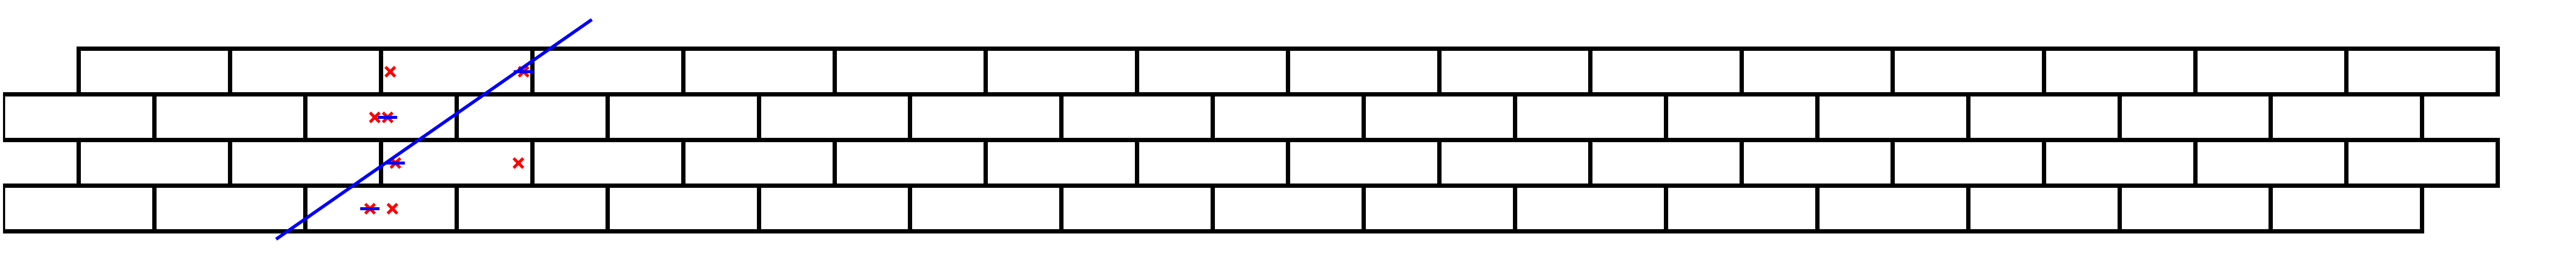

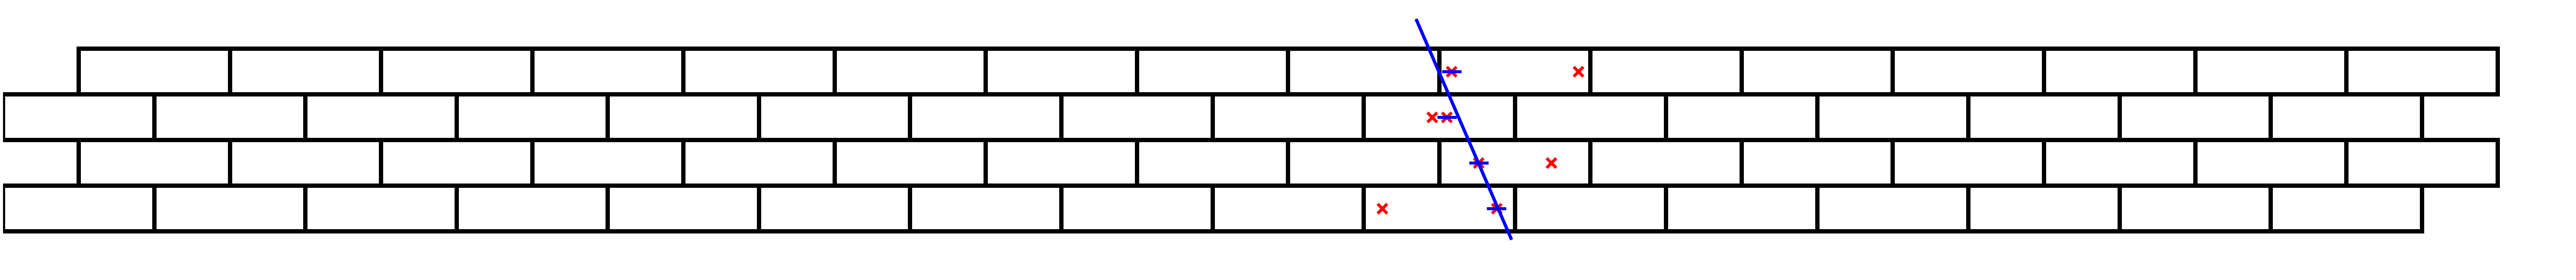

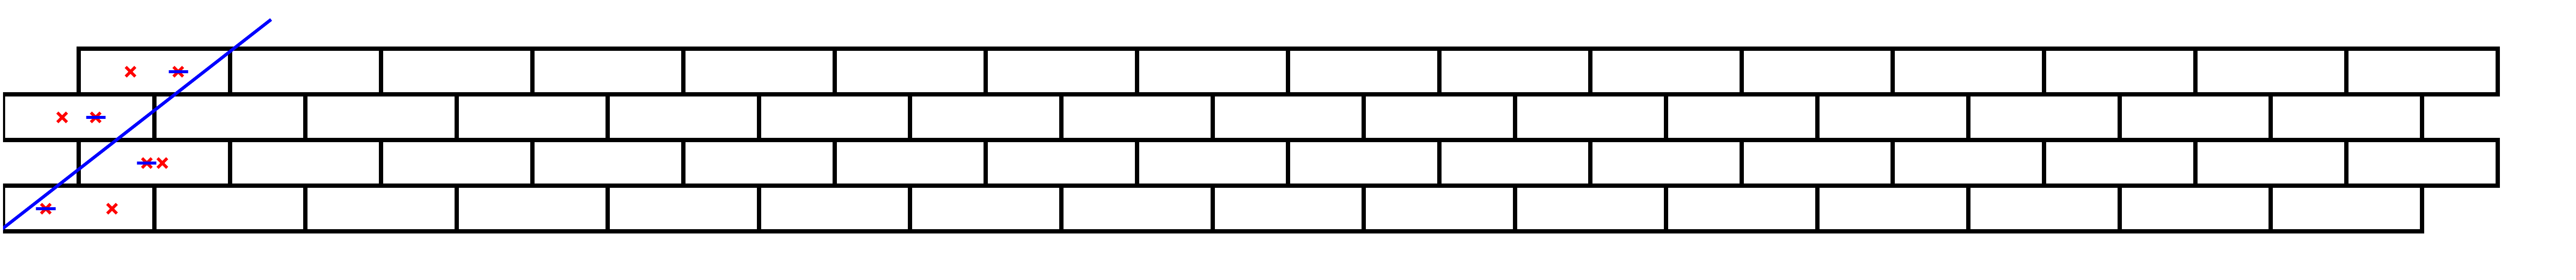

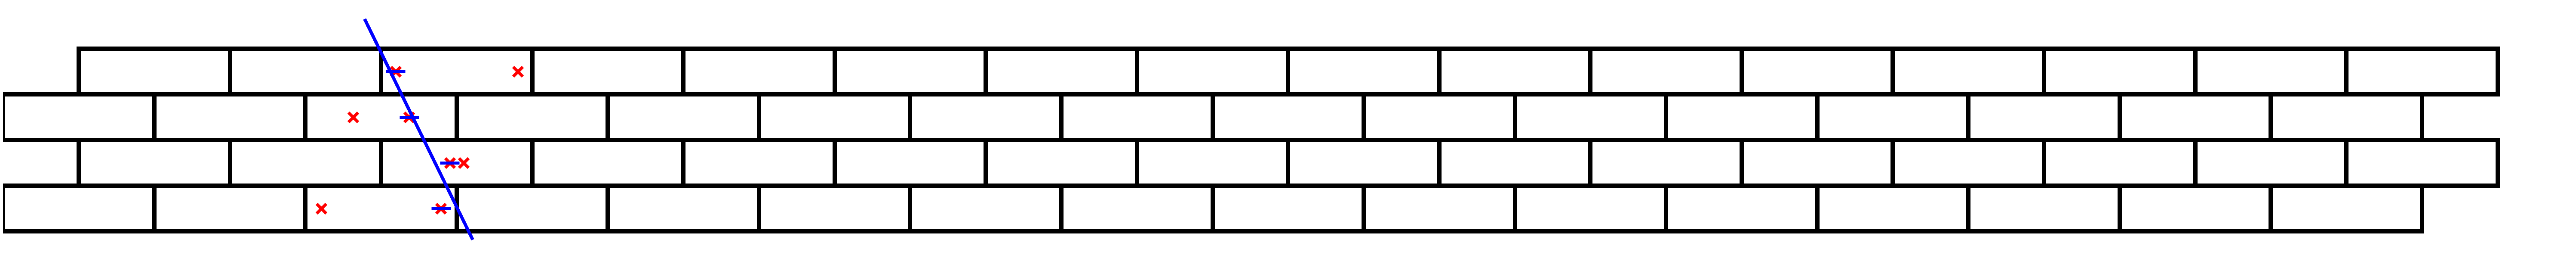

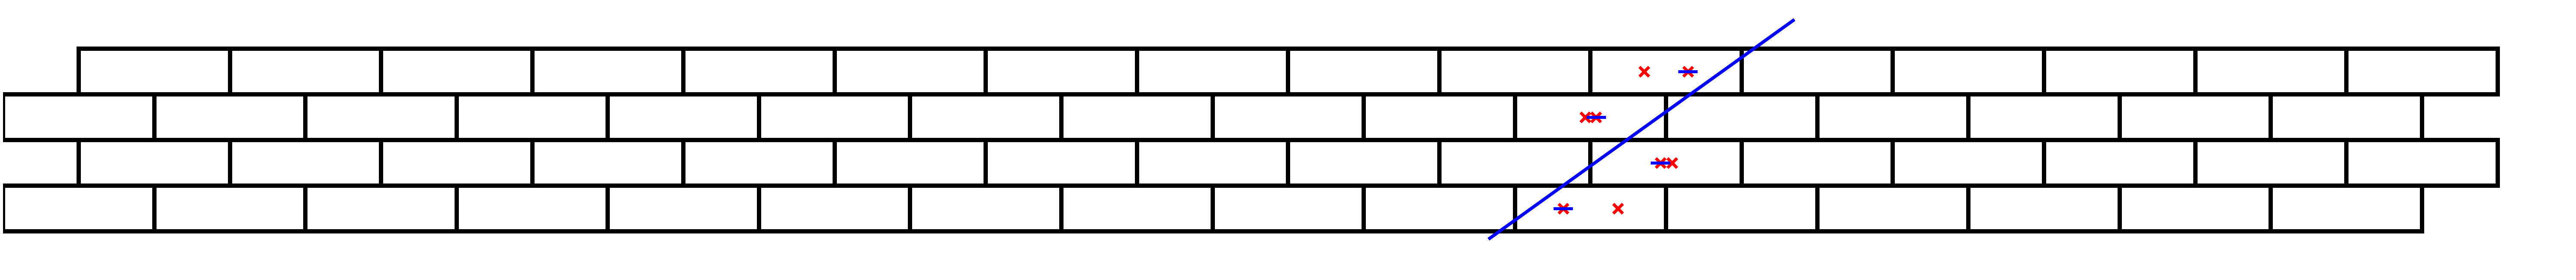

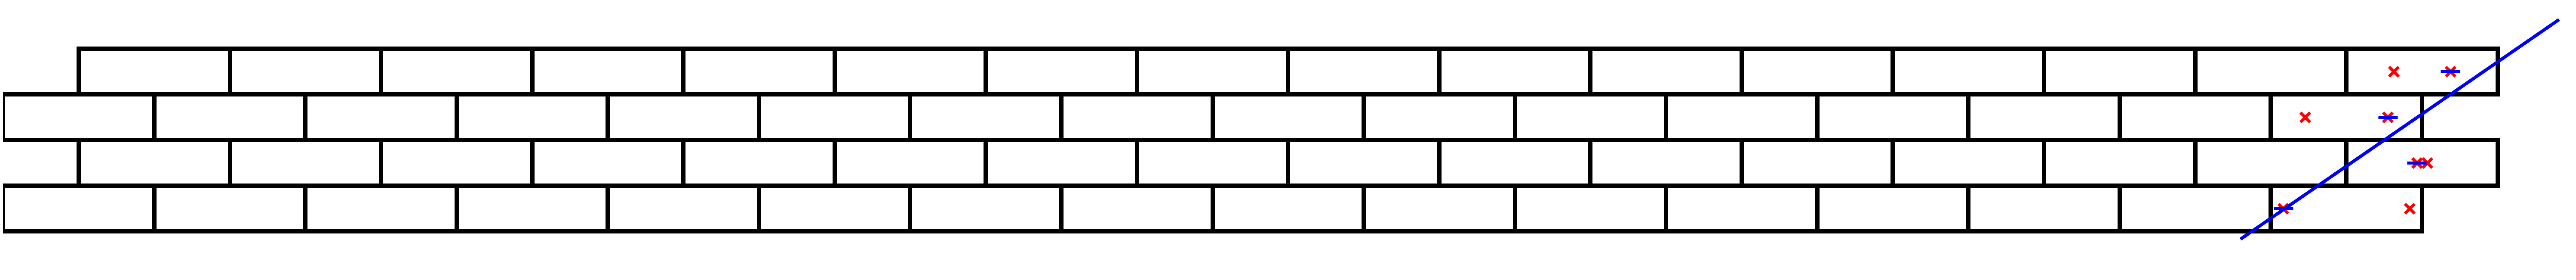

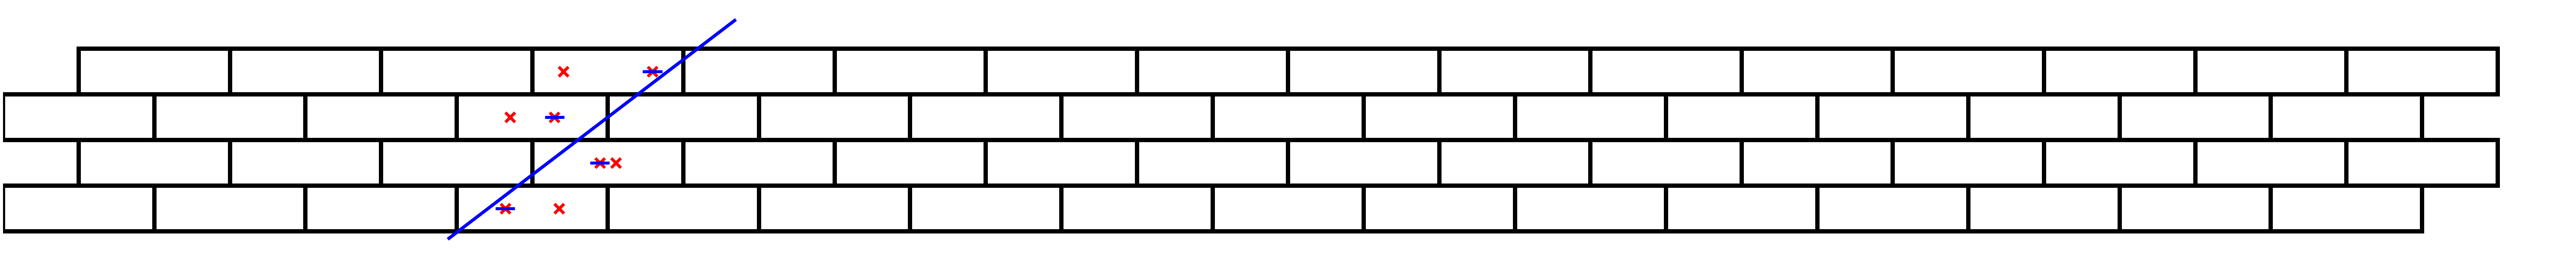

In [35]:
%%time
#plot
delta_x = 42/(2*390)*(50) 

def event_and_line_plot(event):
    
    fig,ax1 = plt.subplots(figsize=(1.5*4.2*17,1.5*1.3*6))
    
    dx = 42
    dy = 13
    
    ax1.set_xlim(0,42*16 + 42)
    ax1.set_ylim(-13,13*4 + 13)

    xr = event['XR'].to_numpy()
    xl = event['XL'].to_numpy()
    X = event['X_BEST'].to_numpy()
    Y = event['Y'].to_numpy()

    x_1 = x_3 = np.arange(16)*dx 
    x_2 = x_4 = x_1 + dx/2
    [y_1, y_2, y_3, y_4] = np.arange(4)*dy 


    for i in range(16):
        rect = patches.Rectangle((x_1[i],y_1),dx,dy,linewidth=10,edgecolor='black',facecolor='none')
        ax1.add_patch(rect)
    
        rect = patches.Rectangle((x_2[i],y_2),dx,dy,linewidth=10,edgecolor='black',facecolor='none')
        ax1.add_patch(rect)
    
        rect = patches.Rectangle((x_3[i],y_3),dx,dy,linewidth=10,edgecolor='black',facecolor='none')
        ax1.add_patch(rect)
        
        rect = patches.Rectangle((x_4[i],y_4),dx,dy,linewidth=10,edgecolor='black',facecolor='none')
        ax1.add_patch(rect)
        
        ax1.axis('off')
        
    ax1.scatter(xr,Y, marker = 'x', c = 'red', s = 500, linewidth = 7)
    ax1.scatter(xl,Y, marker = 'x', c = 'red', s = 500, linewidth = 7)
    ax1.errorbar(X, Y, xerr=delta_x, fmt='.', c = 'blue', linewidth = 7) 
    ax1.plot([(-2-event.Q)/event.M,(60-event.Q)/event.M] ,[-2,60], c= 'blue', linewidth = 7) 
    return ax1

for i in np.unique(df2.ORBIT_CNT.values)[:10] :
    try:
        event = df2.groupby(['ORBIT_CNT','EVENT']).get_group((i,1))
        event_and_line_plot(event)
    except:
        event = df2.groupby(['ORBIT_CNT']).get_group(i)
        event_and_line_plot(event)

In [36]:
%%time 
# Experimental uncertainty compatibility check

def exp_unc_compatib_check(event): 
    if (np.abs(event.X_BEST - (event.Y-event.Q)/event.M)).max() < delta_x : 
        return event 
    else : 
        return None 

df3 = df2.groupby(['ORBIT_CNT','EVENT'], group_keys=False)\
                                       .apply(exp_unc_compatib_check)\
                                       .dropna()\
                                       .reset_index()\
                                       .drop(['index'],axis=1) 
print("n. of unique events before:",len(df2.groupby(["ORBIT_CNT","EVENT"]).nunique()))
print("n. of unique events now:",len(df3.groupby(["ORBIT_CNT","EVENT"]).nunique()))
#df3

n. of unique events before: 28878
n. of unique events now: 2228
CPU times: user 21.4 s, sys: 12.9 ms, total: 21.4 s
Wall time: 21.5 s


CPU times: user 849 ms, sys: 3.98 ms, total: 853 ms
Wall time: 859 ms


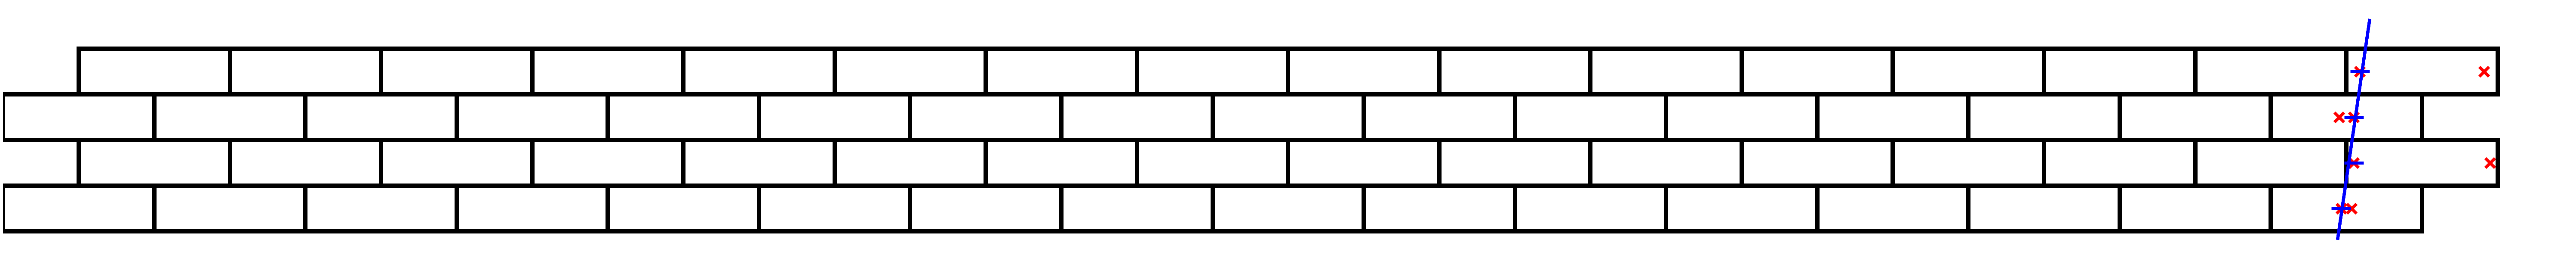

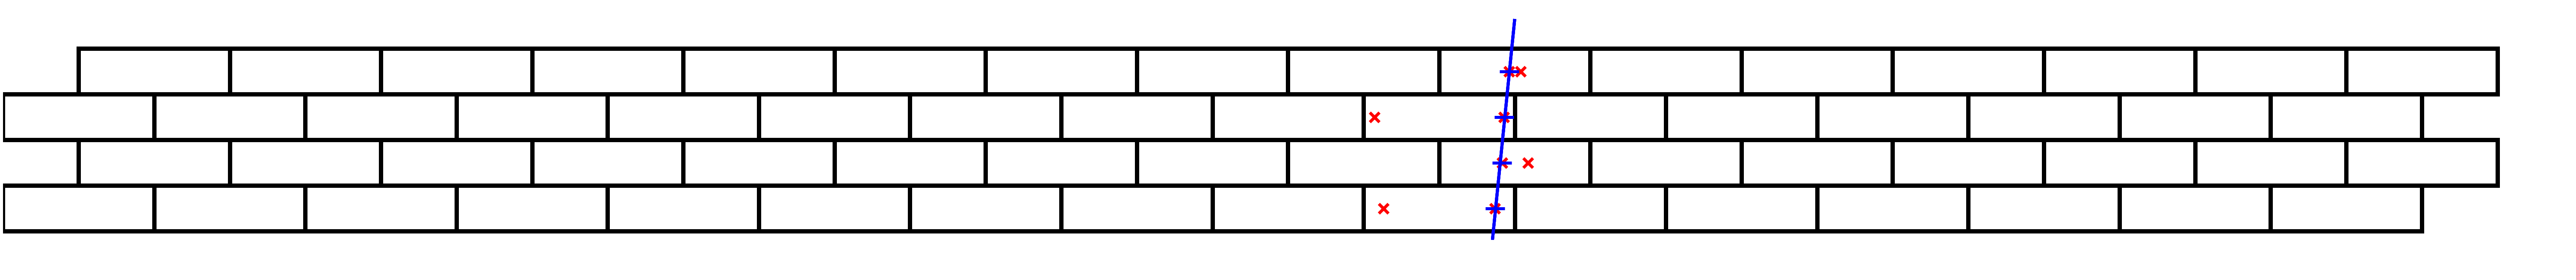

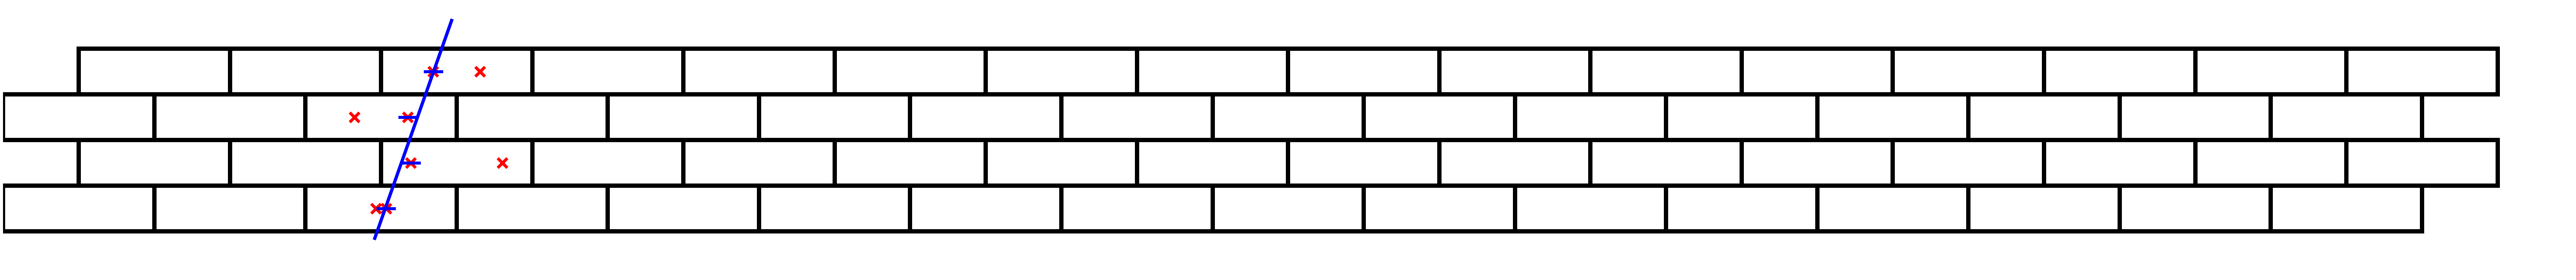

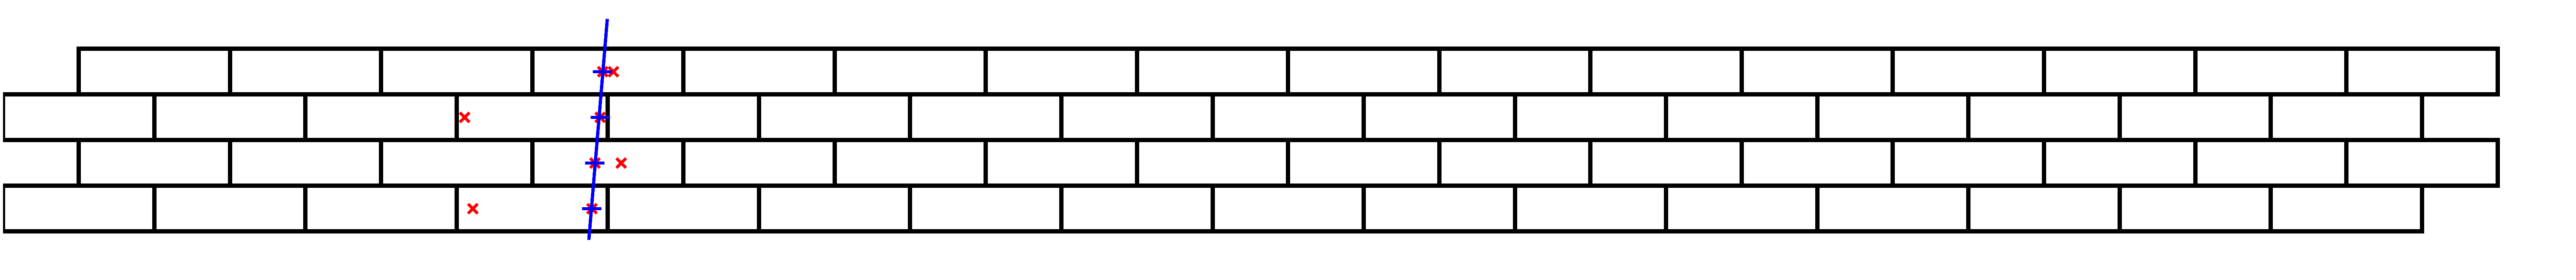

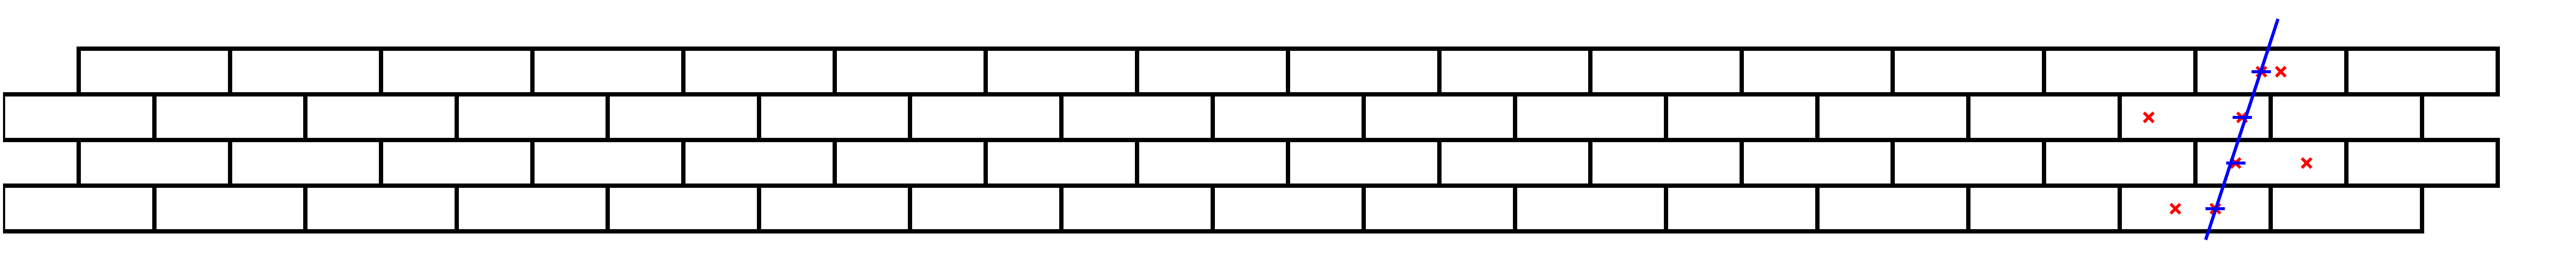

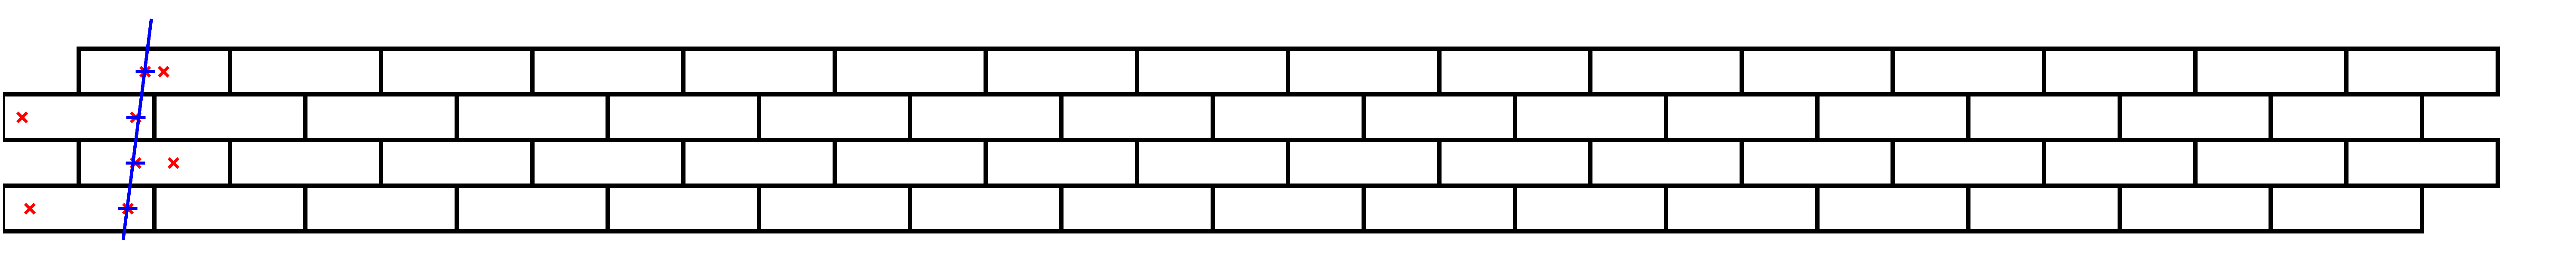

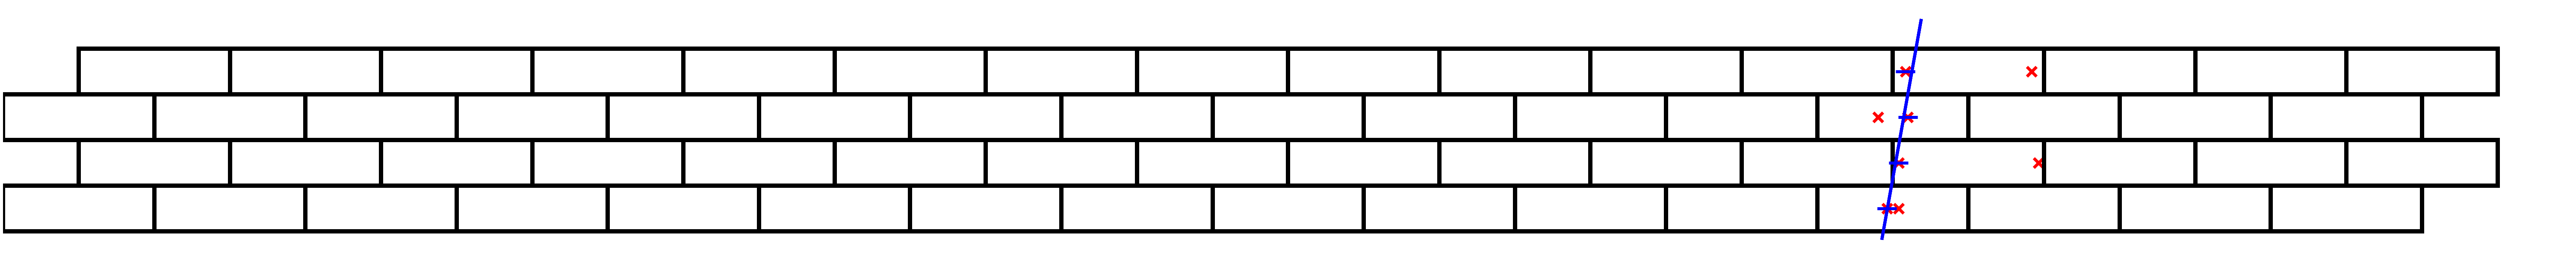

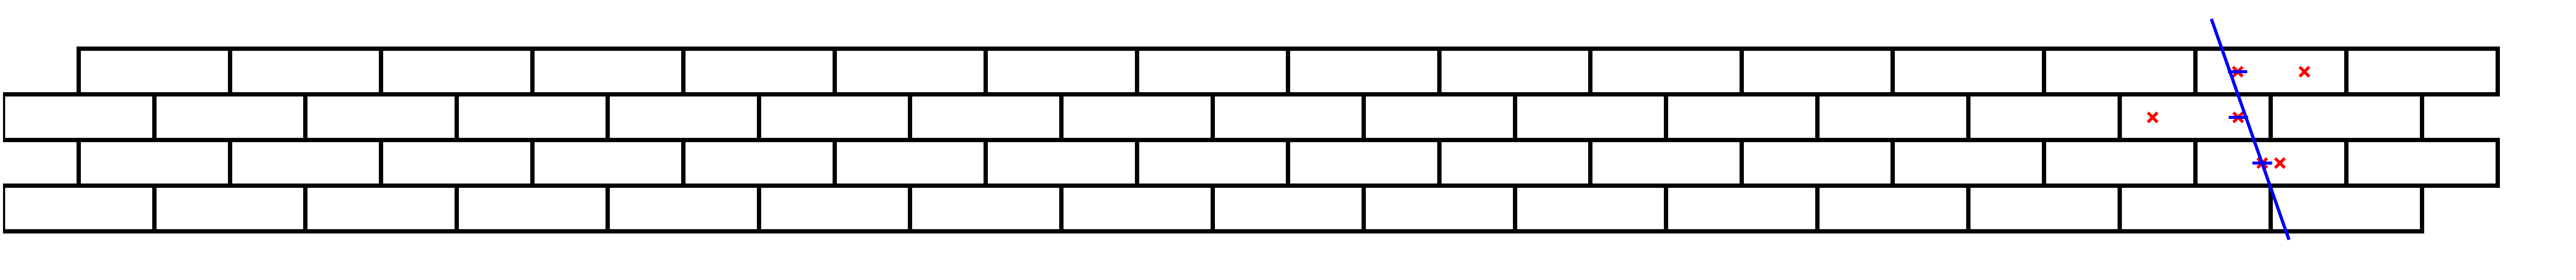

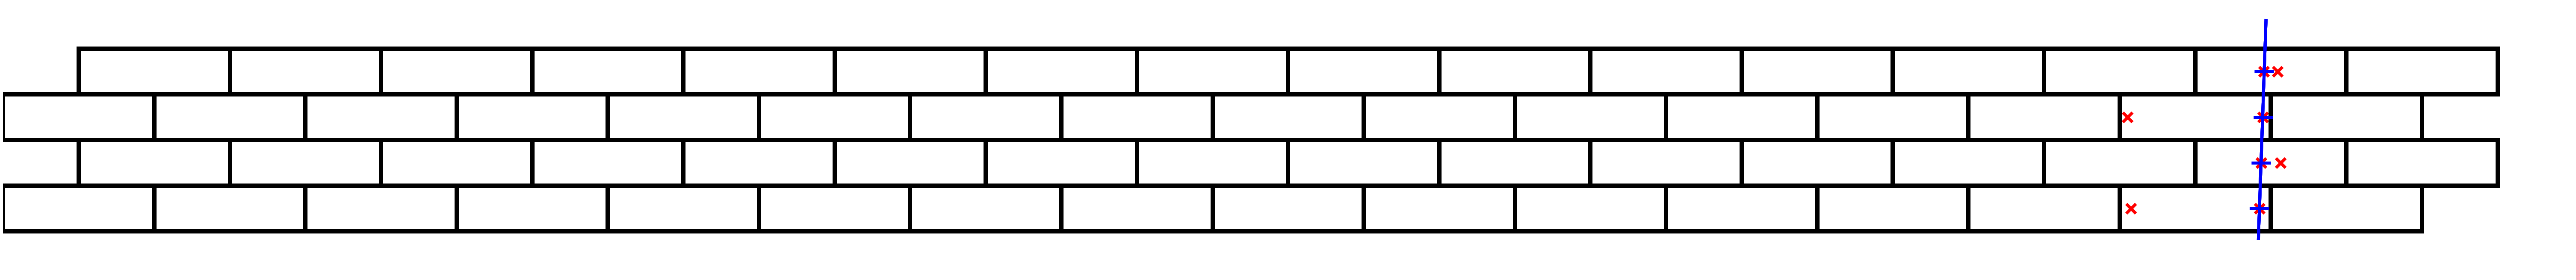

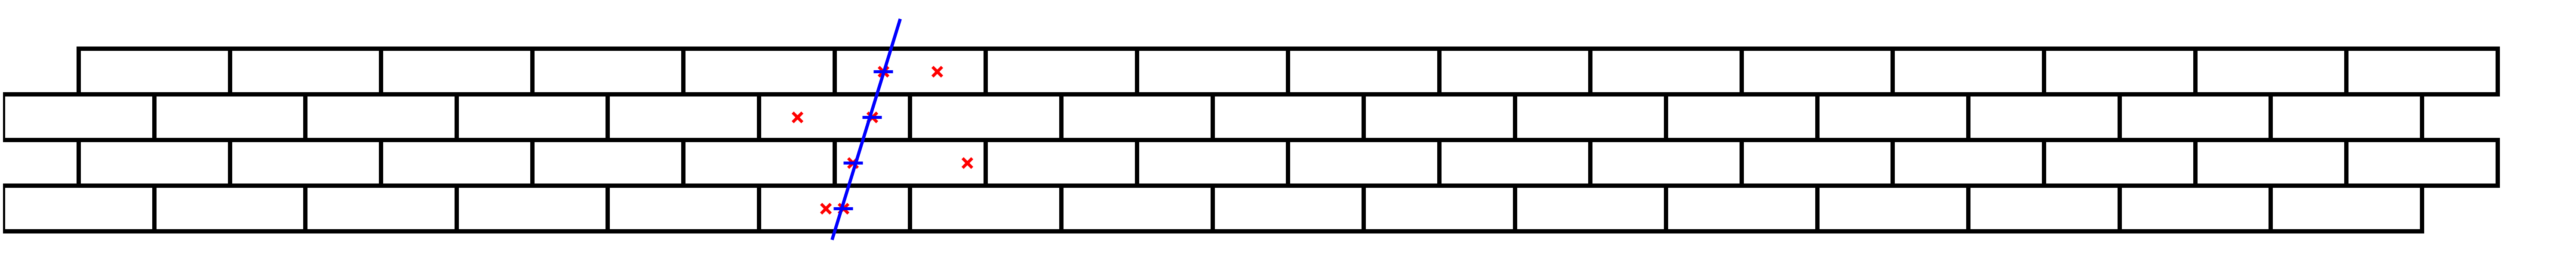

In [37]:
%%time 
#plot aggiornato
for i in np.unique(df3.ORBIT_CNT.values)[:10] :
    try:
        event = df3.groupby(['ORBIT_CNT','EVENT']).get_group((i,1))
        event_and_line_plot(event)
    except:
        event = df3.groupby(['ORBIT_CNT']).get_group(i)
        event_and_line_plot(event)